In [1]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

In [24]:
if 1:
    mreal    = np.single
    mcomplex = np.csingle
else:
    mreal = np.double
    mcomplex = np.cdouble
    
# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

class GramExtensionScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal) 
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal) 

        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0) 
        self.p       = config.get("p", 1) 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta 

        psi = self.psi.astype(self.minput) 

        mass_before = np.sum(np.abs(psi)[2:-2])
        
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 


        al[self.proj+1:] = 0
        ar[self.proj+1:] = 0
        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex) 
        
        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex) 

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/120) 
        fhat = fhat.astype(self.mcomplex) 
        
        self.psi = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(np.csingle)
        mass_after = np.sum(np.abs(self.psi)[2:-2]) 

        print("Relative mass loss: ", mass_after/mass_before)
        self.t += dt
        self.counter += 1 



    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    

class GramExtensionNoRoundoffScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal)
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal)
        self.F1 = (self.Fe - self.Fo)/2
        self.F2 = (self.Fe + self.Fo)/2
        self.F1 = self.F1.astype(self.mreal)
        self.F2 = self.F2.astype(self.mreal)

        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0) 
        self.p       = config.get("p", 1) 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta 

        psi = self.psi.astype(self.minput) 

        mass_before = np.sum(np.abs(psi))

        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        a1     = self.Pl @ fl 
        a2     = self.Pr @ fr 


        a1[self.proj+1:] = 0
        a2[self.proj+1:] = 0
        fmatch = a1 @ self.F1 + a2 @ self.F2

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex) 
        
        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex) 

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/120 + arg**6/720) 
        fhat = fhat.astype(self.mcomplex) 
        
        self.psi = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(self.minput)

        mass_after = np.sum(np.abs(self.psi)) 

        print("Relative mass loss: ", mass_after/mass_before)
        self.t += dt
        self.counter += 1 
        return fhat



    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    



Relative mass loss:  1.0000014


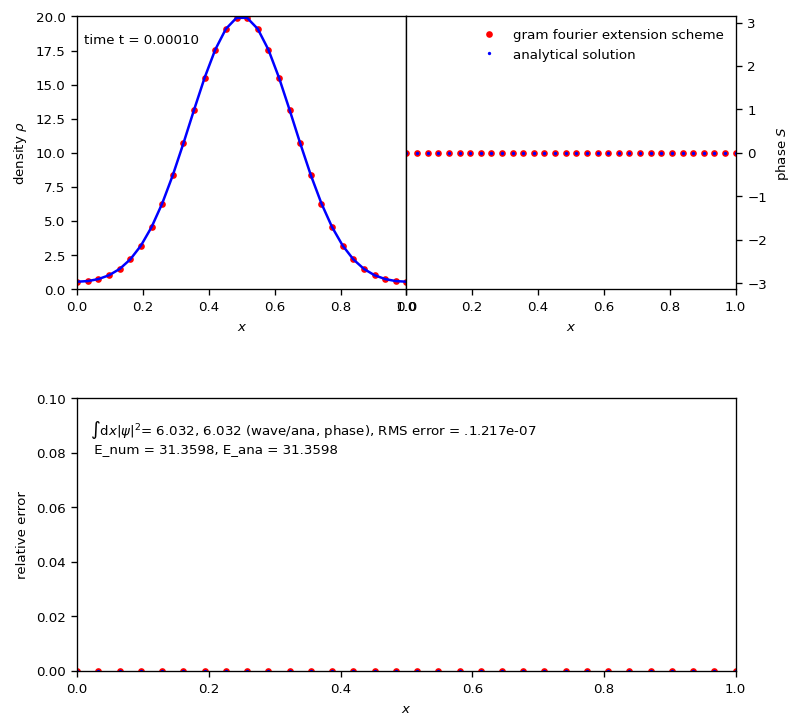

In [26]:
def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.2):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi


def standingWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return np.exp(1j*(k*xx - omega * t))


c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.1
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 14

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["extensionNDelta"]            = 14
c["extensionND"]                = 34
c["p"]                          = 50
c["inputPrecision"] = np.csingle 

scheme = GramExtensionScheme(c, periodic1DGaussian)
scheme.step(1e-4)

animation.drawFrame(scheme) 


TypeError: bad operand type for abs(): 'NoneType'

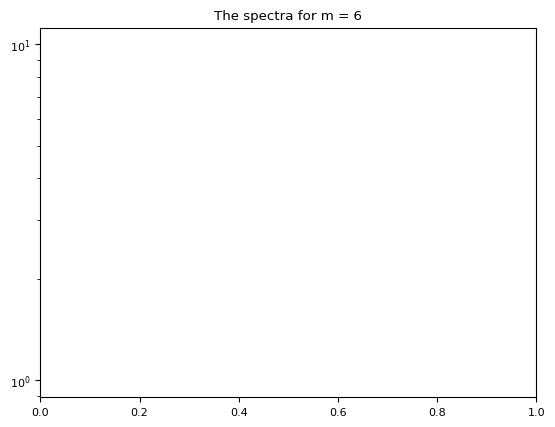

In [8]:
import pandas as pd 

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.1
c["resolution"]                 = 1632
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0.45, 0.55]
c["xlim"]                       = [0.45, 0.55]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 14

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["extensionNDelta"]            = 14
nd = 38
c["extensionND"]                = nd
c["p"]                          = 3
c["projectionOrder"]            = 10
c["inputPrecision"] = np.csingle 
for m in [6, 8, 10, 12, 14]: 
    c["extensionNDelta"]            = m
    c["projectionOrder"]            = m
    c["inputPrecision"]             = np.csingle
    c["realPrecision"]              = np.double
    c["complexPrecision"]           = np.cdouble
    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat1 = scheme.step(1e-4) 

    c["realPrecision"]              = np.single
    c["complexPrecision"]           = np.cdouble

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat2 = scheme.step(1e-4) 


    c["realPrecision"]              = np.double
    c["complexPrecision"]           = np.csingle

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat3 = scheme.step(1e-4) 

    c["realPrecision"]              = np.single
    c["complexPrecision"]           = np.csingle

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat4 = scheme.step(1e-4) 

    c["inputPrecision"] = np.cdouble 
    c["realPrecision"]              = np.double
    c["complexPrecision"]           = np.cdouble


    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat5 = scheme.step(1e-4) 

    c["realPrecision"]              = np.single
    c["complexPrecision"]           = np.cdouble

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat6 = scheme.step(1e-4) 


    c["realPrecision"]              = np.double
    c["complexPrecision"]           = np.csingle

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat7 = scheme.step(1e-4) 

    c["realPrecision"]              = np.single
    c["complexPrecision"]           = np.csingle

    scheme = GramExtensionScheme(c, periodic1DGaussian) 

    fhat8 = scheme.step(1e-4) 

    plt.title(f"The spectra for m = {m}") 
    plt.yscale("log") 
    plt.plot(np.abs(fhat1), lw = 8, label="SDD") 
    plt.plot(np.abs(fhat2), lw = 7, label="SSD") 
    plt.plot(np.abs(fhat3), lw = 6, label="SDS") 
    plt.plot(np.abs(fhat4), lw = 5, label="SSS")
    plt.plot(np.abs(fhat5), lw = 4, label="DDD") 
    plt.plot(np.abs(fhat6), lw = 3, label="DSD") 
    plt.plot(np.abs(fhat7), lw = 2, label="DDS") 
    plt.plot(np.abs(fhat8), lw = 1, label="DSS")
    plt.legend()
    plt.savefig(f"../SingleVsDouble/m={m}_ext={nd}_filter.png")
    plt.show()

In [4]:
import pandas as pd 

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.001
c["resolution"]                 = 64
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 8#12

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

precisions = [(np.single, np.csingle), (np.double, np.csingle), (np.double, np.cdouble)]
extensions = []
deltas = [6, 8, 10, 12, 14]
ps = [1, 3, 10, 30, 50, 100]
projectionOrders = [0.5, 0.9, 1]
errors = []

df = pd.DataFrame([], columns=["real precision", "complex precision", "Nd", "NDelta", "m", "p", "error"])
for precision in precisions: 
    for extension in extensions: 
        for delta in deltas: 
            for p in ps: 
                for projectionOrder in projectionOrders:
                    if precision[0] == np.single:
                        rp = "single"
                    else:
                        rp = "double"
                    if precision[1] == np.csingle:
                        dp = "single"
                    else: 
                        dp = "double"

                    c["realPrecision"]              = precision[0]
                    c["complexPrecision"]           = precision[1] 
                    c["extensionNDelta"]            = delta
                    c["extensionND"]                = extension 
                    c["p"]                          = p 
                    order = int(delta * projectionOrder)
                    c["projectionOrder"]            = order

                    scheme = GramExtensionScheme(c, periodic1DGaussian) 
                    scheme.run()

                    error = scheme.computeRMSError()
                    print(f"Nd: {extension} NDelta: {delta} m: {order} p: {p} Error: {error}")

                    df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "error":error}, ignore_index=True)
                    errors.append(error)

In [17]:

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    #def getUpdatedFields(self, t, dt, old_psi):
    def step(self, dt):
        #self.psi = np.copy(old_psi)

        print_grid = self.print_grid
        
        if 0:
            plt.title("Before boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        if 1:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)

            if print_grid:
                print(f"Writing BC to {self.boundary}")


            #Set outer ghost zone
            self.psi[self.boundary] = f[self.boundary]

        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("After boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        self.t += dt
        #return self.psi# - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])
    

    def computeRMSError(self):
        errors = np.zeros(self.NPatch)
        for i in range(self.NPatch):
            errors[i] = self.patches[i].computeRMSError()

        return np.sqrt(np.mean(errors**2))

In [25]:
import pandas as pd 


def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1e-2
c["resolution"]                 = 128
c["patchSize"]                  = 128
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.05
c["printGrid"]                  = False
c["alpha"]                      = 16 * np.log(10)
c["p"]                          = 50
c["projectionOrder"]            = 12
c["extensionGamma"]             = 150
c["extensionG"]                 = 63
c["inputPrecision"]             = np.csingle 


precisions = [(np.double, np.cdouble)]
extensions = [28]
deltas = [8, 12]
ps = [50, 1000]
projectionOrders = [1]
boundarySizes = [6, 8]
errors = []

df = pd.DataFrame([], columns=["real precision", "complex precision", "Nd", "NDelta", "m", "p", "boundary", "error"])
for boundarySize in boundarySizes:
    for precision in precisions: 
        for extension in extensions: 
            for delta in deltas: 
                for p in ps: 
                    for projectionOrder in projectionOrders:
                        if precision[0] == np.single:
                            rp = "single"
                        else:
                            rp = "double"
                        if precision[1] == np.csingle:
                            dp = "single"
                        else: 
                            dp = "double"
                        c["boundarySize"]               = boundarySize
                        c["realPrecision"]              = precision[0]
                        c["complexPrecision"]           = precision[1] 
                        c["extensionNDelta"]            = delta
                        c["extensionND"]                = extension 
                        c["p"]                          = p 
                        order = int(delta * projectionOrder)
                        c["projectionOrder"]            = order

                        scheme = SubregionScheme(c, periodic1DGaussian, GramExtensionNoRoundoffScheme) 
                        scheme.run()

                        error = scheme.computeRMSError()
                        print(f"Nd: {extension} NDelta: {delta} m: {order} p: {p} Error: {error}")

                        df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)
                        errors.append(error)

df.to_pickle("larger_patches")

Finished in 3226 time steps
Nd: 28 NDelta: 8 m: 8 p: 50 Error: 1.2405383819328285e-05


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 8 m: 8 p: 1000 Error: 2.2590691455535685e-06


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 12 m: 12 p: 50 Error: 1.3544830518749043e-05


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 12 m: 12 p: 1000 Error: 2.8498071795853045e-06


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 8 m: 8 p: 50 Error: 1.1843704147717415e-05


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 8 m: 8 p: 1000 Error: 3.700560868451276e-06


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 12 m: 12 p: 50 Error: 1.2795555711732533e-05


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


Finished in 3226 time steps
Nd: 28 NDelta: 12 m: 12 p: 1000 Error: 3.128896836532946e-06


/tmp/ipykernel_184339/430891753.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"real precision": rp, "complex precision": dp, "Nd": extension, "NDelta":delta, "m":order, "p":p, "boundary":boundarySize, "error":error}, ignore_index=True)


## Larger patches

In [24]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,double,double,28,8,8,50,6,0.000036
1,double,double,28,8,8,1000,6,0.000013
2,double,double,28,12,12,50,6,0.000039
3,double,double,28,12,12,1000,6,0.000016
4,double,double,28,8,8,50,8,0.000010
5,double,double,28,8,8,1000,8,0.000015
6,double,double,28,12,12,50,8,0.000036
7,double,double,28,12,12,1000,8,0.000015


## Smaller patches

In [22]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,double,double,28,8,8,50,6,0.000036
1,double,double,28,8,8,1000,6,0.000013
2,double,double,28,12,12,50,6,0.000039
3,double,double,28,12,12,1000,6,0.000016
4,double,double,28,8,8,50,8,0.000010
5,double,double,28,8,8,1000,8,0.000015
6,double,double,28,12,12,50,8,0.000036
7,double,double,28,12,12,1000,8,0.000015


## Single (less roundoff) + 4th order expansion

In [39]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,single,28,6,6,10,6,0.000006
1,single,single,28,6,6,30,6,0.000007
2,single,single,28,6,6,50,6,0.000007
3,single,single,28,6,6,100,6,0.000007
4,single,single,28,8,8,10,6,0.000009
5,single,single,28,8,8,30,6,0.000009
6,single,single,28,8,8,50,6,0.000009
7,single,single,28,8,8,100,6,0.000009
8,single,single,28,10,10,10,6,NaN
9,single,single,28,10,10,30,6,NaN


## Single + 3rd order expansion

In [28]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,single,28,6,6,10,6,0.000009
1,single,single,28,6,6,30,6,0.000010
2,single,single,28,6,6,50,6,0.000010
3,single,single,28,6,6,100,6,0.000009
4,single,single,28,8,8,10,6,0.000009
5,single,single,28,8,8,30,6,0.000010
6,single,single,28,8,8,50,6,0.000010
7,single,single,28,8,8,100,6,0.000010
8,single,single,28,10,10,10,6,NaN
9,single,single,28,10,10,30,6,NaN


## Single + 4th order expansion

In [25]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,single,28,6,6,10,6,0.000007
1,single,single,28,6,6,30,6,0.000007
2,single,single,28,6,6,50,6,0.000007
3,single,single,28,6,6,100,6,0.000007
4,single,single,28,8,8,10,6,0.000008
5,single,single,28,8,8,30,6,0.000008
6,single,single,28,8,8,50,6,0.000008
7,single,single,28,8,8,100,6,0.000008
8,single,single,28,10,10,10,6,NaN
9,single,single,28,10,10,30,6,NaN


## Single + 5th order expansion

In [32]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,single,28,6,6,10,6,0.000009
1,single,single,28,6,6,30,6,NaN
2,single,single,28,6,6,50,6,NaN
3,single,single,28,6,6,100,6,NaN
4,single,single,28,8,8,10,6,0.000010
5,single,single,28,8,8,30,6,NaN
6,single,single,28,8,8,50,6,NaN
7,single,single,28,8,8,100,6,NaN
8,single,single,28,10,10,10,6,NaN
9,single,single,28,10,10,30,6,NaN


## Both matrices and FFT in double + 4th order expansion

In [22]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,double,double,28,8,8,10,6,6.653276e-08
1,double,double,28,8,8,30,6,5.274461e-08
2,double,double,28,8,8,50,6,6.740617e-08
3,double,double,28,8,8,100,6,4.020809e-08
4,double,double,28,10,10,10,6,5.866166e-08
5,double,double,28,10,10,30,6,6.287592e-08
6,double,double,28,10,10,50,6,5.541395e-08
7,double,double,28,10,10,100,6,6.435319e-08
8,double,double,28,12,12,10,6,6.991939e-08
9,double,double,28,12,12,30,6,4.589808e-08


## Both matrices and FFT in double

In [117]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,double,double,28,8,8,10,6,7.115517e-08
1,double,double,28,8,8,30,6,7.679781e-08
2,double,double,28,8,8,50,6,5.141327e-08
3,double,double,28,8,8,100,6,5.198172e-03
4,double,double,28,10,10,10,6,4.928630e-08
5,double,double,28,10,10,30,6,6.297955e-08
6,double,double,28,10,10,50,6,4.011033e-08
7,double,double,28,10,10,100,6,NaN
8,double,double,28,12,12,10,6,7.745421e-08
9,double,double,28,12,12,30,6,7.004031e-02


## Only FFT in double but matrices in single

In [120]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,double,28,8,8,10,6,1.248853e-06
1,single,double,28,8,8,30,6,1.318935e-06
2,single,double,28,8,8,50,6,1.480121e-06
3,single,double,28,8,8,100,6,2.057470e-02
4,single,double,28,10,10,10,6,6.018850e-07
5,single,double,28,10,10,30,6,4.815304e-07
6,single,double,28,10,10,50,6,7.220927e-07
7,single,double,28,10,10,100,6,NaN
8,single,double,28,12,12,10,6,3.684348e-06
9,single,double,28,12,12,30,6,3.709617e-06


In [ ]:

pd.options.display.max_rows = 4000

df

In [122]:
df

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
0,single,single,28,6,3,1,6,3.830414e-02
1,single,single,28,6,5,1,6,3.830413e-02
2,single,single,28,6,6,1,6,3.830413e-02
3,single,single,28,6,3,3,6,7.535208e-06
4,single,single,28,6,5,3,6,6.547634e-06
5,single,single,28,6,6,3,6,6.547634e-06
6,single,single,28,6,3,10,6,NaN
7,single,single,28,6,5,10,6,6.699301e-06
8,single,single,28,6,6,10,6,6.699301e-06
9,single,single,28,6,3,30,6,NaN


In [96]:
import pandas as pd

df = pd.read_pickle("my_really_long_single_double_test")
df = df.dropna()
df = df[df.error < 1e-4]

df["error"] = np.log10(df["error"])

In [97]:
df.columns

Index(['real precision', 'complex precision', 'Nd', 'NDelta', 'm', 'p',
       'boundary', 'error'],
      dtype='object')

In [98]:
dd = df.loc[df["real precision"] == "double", :].loc[df["complex precision"] == "double", :]

In [108]:
sds = df.loc[df["complex precision"] == "single", :]

In [99]:
ss = df.loc[df["real precision"] == "single", :].loc[df["complex precision"] == "single", :]

In [100]:
ds = df.loc[df["real precision"] == "double", :].loc[df["complex precision"] == "single", :]

In [110]:
ss

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
3,single,single,28,6,3,3,6,-5.122905
4,single,single,28,6,5,3,6,-5.183916
5,single,single,28,6,6,3,6,-5.183916
7,single,single,28,6,5,10,6,-5.173971
8,single,single,28,6,6,10,6,-5.173971
21,single,single,28,8,4,3,6,-5.286056
22,single,single,28,8,7,3,6,-5.261226
23,single,single,28,8,8,3,6,-5.261226
25,single,single,28,8,7,10,6,-5.141421
26,single,single,28,8,8,10,6,-5.141421


In [111]:
ds

,real precision,complex precision,Nd,NDelta,m,p,boundary,error
183,double,single,28,6,3,3,6,-5.165615
184,double,single,28,6,5,3,6,-5.185123
185,double,single,28,6,6,3,6,-5.185123
187,double,single,28,6,5,10,6,-5.192123
188,double,single,28,6,6,10,6,-5.192123
201,double,single,28,8,4,3,6,-5.217135
202,double,single,28,8,7,3,6,-5.182385
203,double,single,28,8,8,3,6,-5.182385
205,double,single,28,8,7,10,6,-5.115305
206,double,single,28,8,8,10,6,-5.115305


In [88]:
import seaborn as sns
sns.set()

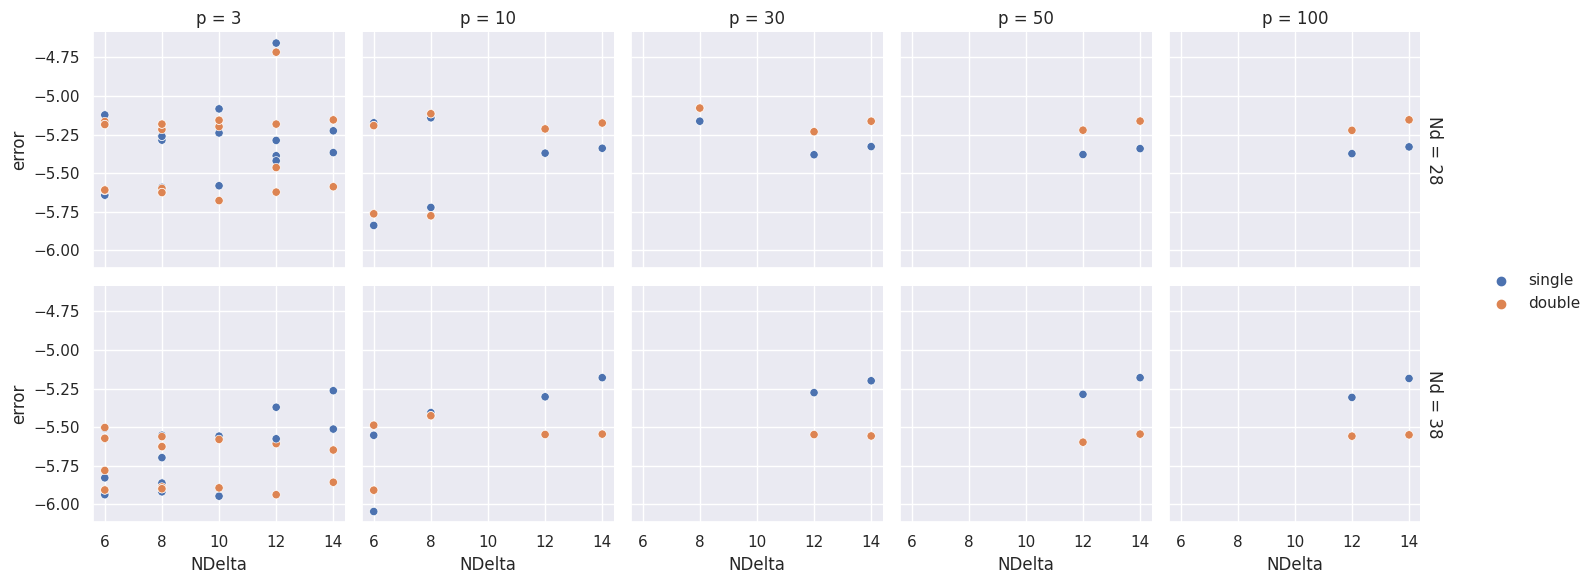

In [109]:

grid = sns.FacetGrid(sds, row="Nd", col="p", margin_titles=True)
grid.map_dataframe(sns.scatterplot, x="NDelta", y="error", hue = "real precision")
grid.add_legend()

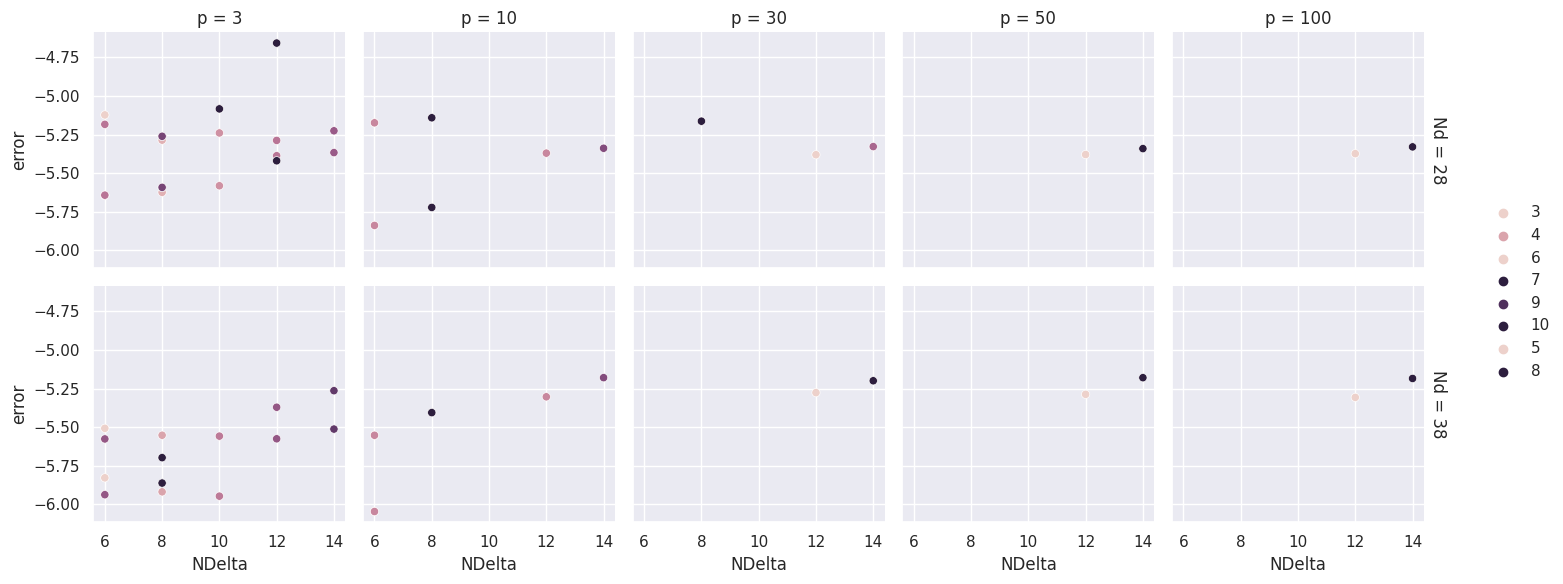

In [107]:

grid = sns.FacetGrid(ss, row="Nd", col="p", margin_titles=True)
grid.map_dataframe(sns.scatterplot, x="NDelta", y="error", hue = "m")
grid.add_legend()

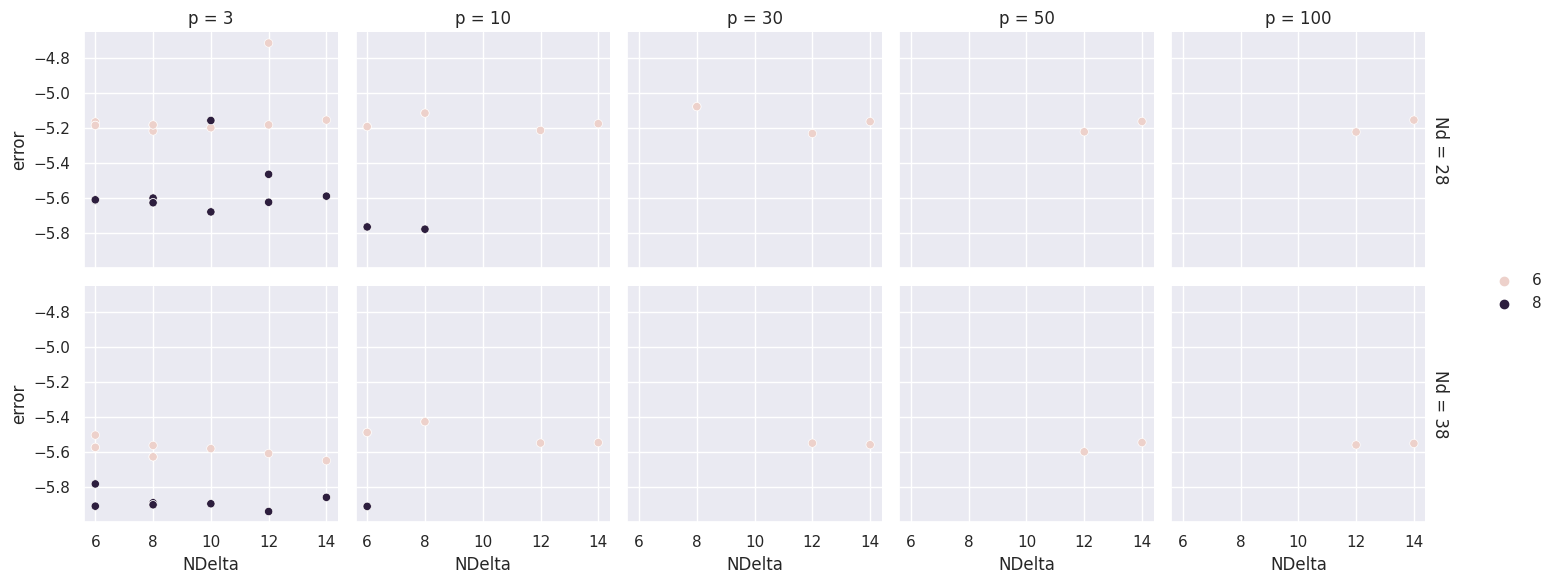

In [104]:

grid = sns.FacetGrid(ds, row="Nd", col="p", margin_titles=True)
grid.map_dataframe(sns.scatterplot, x="NDelta", y="error", hue = "boundary")
grid.add_legend()

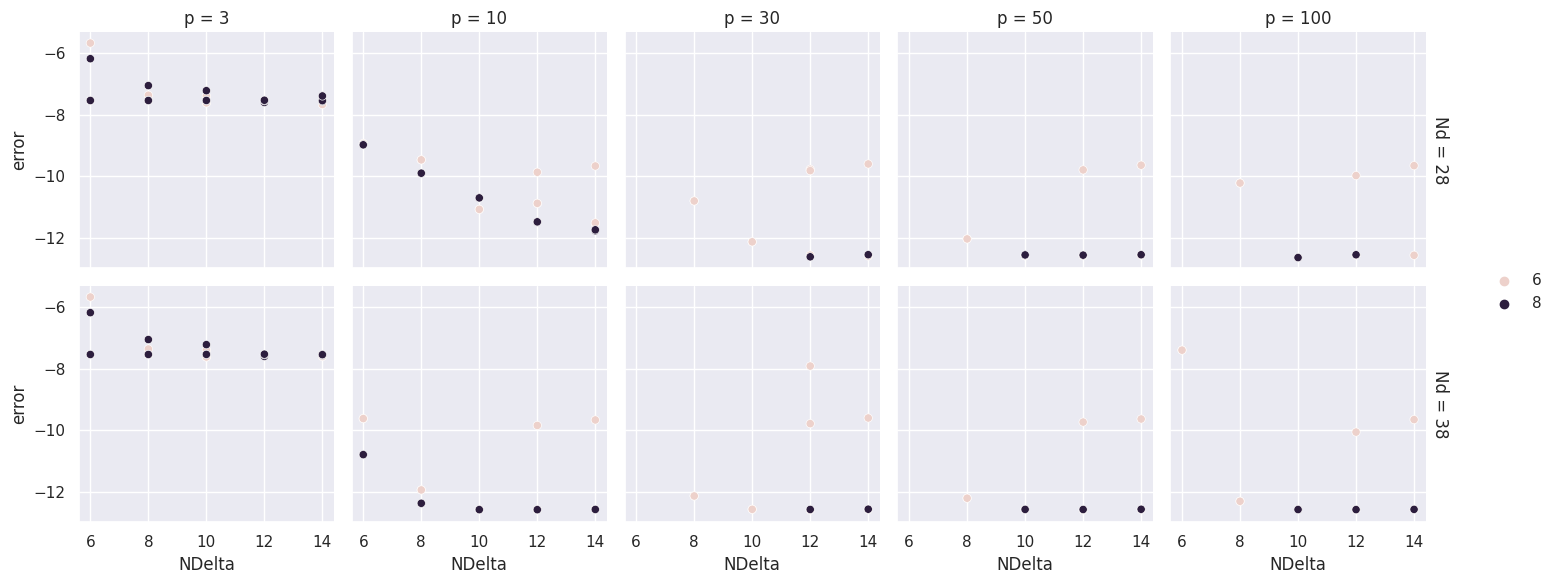

In [106]:

grid = sns.FacetGrid(dd, row="Nd", col="p", margin_titles=True)
grid.map_dataframe(sns.scatterplot, x="NDelta", y="error", hue = "boundary")
grid.add_legend()

<AxesSubplot:xlabel='boundary', ylabel='error'>

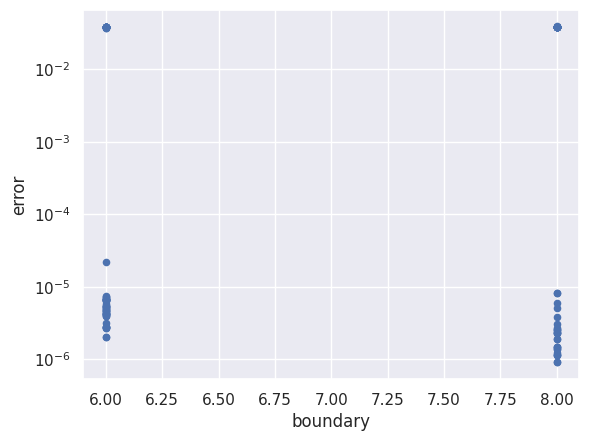

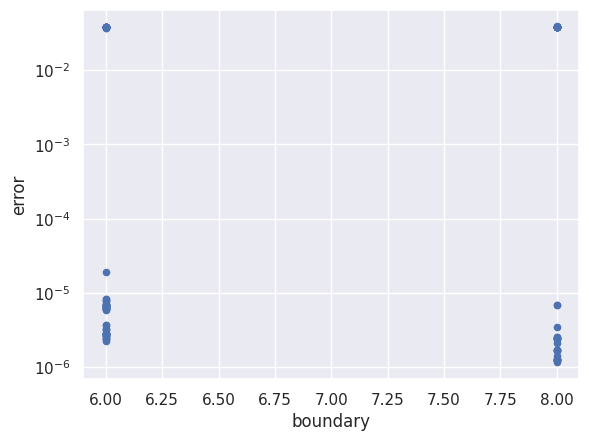

In [36]:
ss.plot.scatter(x="boundary", y="error", logy=True)
ds.plot.scatter(x="boundary", y="error", logy=True)

/home/calab912/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: Maximum allowed size exceeded

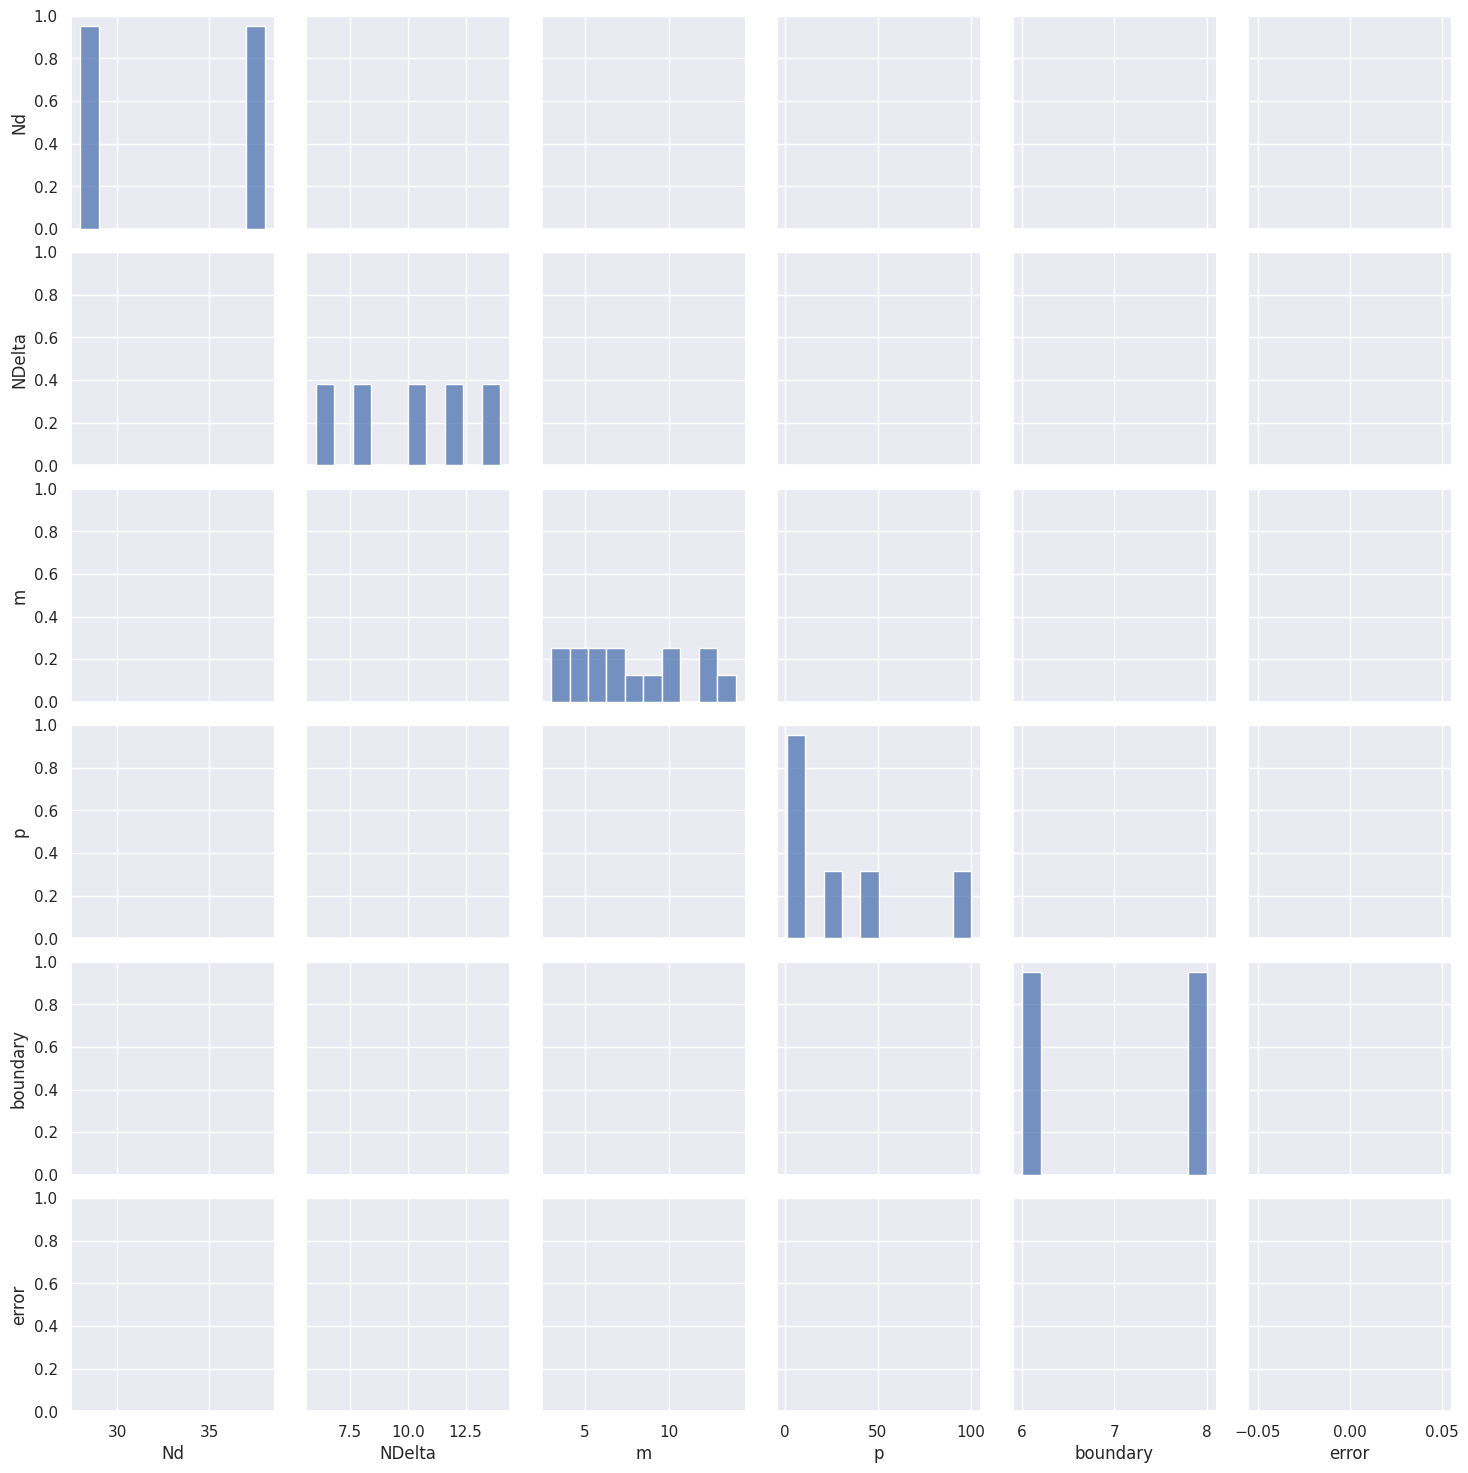

In [19]:
with sns.axes_style('white'):
    sns.jointplot("Nd", "y", data, kind='hex')